# Table of Content

###  1.[Data Preparation](#dp)
[(i)Churn Data](#fcd)
<br/>[(ii)RFM Analysis Data](#rfm) <br/>
[Final Data with RFM Variable](#fd)

### 2.[Exploratory Analysis](#ea)


### 3.[Data Transforamtion for Feature Selection](#pdfs)
[(i)Feature Importance using Random Forest ](#rf)
<br/>[(ii)Recursive Feature Elemination](#rfe)
<br/>[(iii)Feature Importance using Extra Tree Classifier](#etc)
<br/>[(iv)Chi Square](#chi)<br/>[(v) Vote Base Feature Selection](#vfs)
#### [Multicollinearity](#mc)


### 4.[Different model on Training and Testing Set ](#tt)
[(i)Random Forest ](#rf1)
<br/>[(ii)Logistic Regression ](#lr)
<br/>[(iii)Naive Bayes](#nb)
<br/>[(iv)Gradient Boosting](#gb)

### 5.Picking the best [Final Model](#fm) and [saving](#sfm) it for scoring data

### 6.Picking best features and using it for [Scoring Data](#sd)

In [1]:
# importing necessary libraries  
%matplotlib inline
import datetime as dt
import pyodbc 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# data colelction and preprocessing
from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
# for data visualisation and statistical analysis
import numpy as np
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
 
cnn = pyodbc.connect('Driver={SQL Server Native Client 11.0};'
                      'Server=DESKTOP-ATL660H;'
                      'Database=AdventureWorksDW2012;'
                      'Trusted_Connection=yes;')


<a id='dp'> </a>
##  Data Preparation

In [4]:
#Import Factinternetsales from AHG SQL Datawarehouse
fis = pd.read_sql_query("""
SELECT
[CustomerKey]
,[OrderQuantity]
,[SalesAmount]
,[OrderDate]
,[SalesTerritoryKey]
,[SalesOrderNumber]
FROM [dbo].[FactInternetSales]""", cnn)

In [5]:
fis.head()

,CustomerKey,OrderQuantity,SalesAmount,OrderDate,SalesTerritoryKey,SalesOrderNumber
0,21768,1,3578.2700,2010-12-29,6,SO43697
1,28389,1,3399.9900,2010-12-29,7,SO43698
2,25863,1,3399.9900,2010-12-29,1,SO43699
3,14501,1,699.0982,2010-12-29,4,SO43700
4,11003,1,3399.9900,2010-12-29,9,SO43701


In [6]:
fis['OrderDate'].max()

Timestamp('2014-01-28 00:00:00')

In [7]:
ct = pd.read_sql_query("""
SELECT
[CustomerKey]
,[BirthDate]
,[MaritalStatus]
,[Gender]
,[YearlyIncome]
,[TotalChildren]
,[NumberChildrenAtHome]
,[EnglishEducation]
,[EnglishOccupation]
,[HouseOwnerFlag]
,[NumberCarsOwned]
,[DateFirstPurchase]
,[CommuteDistance]
FROM [dbo].[DimCustomer]""", cnn)

In [8]:
#cehcking the new data of customer table 
ct.head(5)

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,1971-10-06,M,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,1976-05-10,S,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,1971-02-09,M,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,1973-08-14,S,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,1979-08-05,S,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [9]:
#Import Factinternetsalesreason from SQL Datawarehouse
fsalesreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[FactInternetSalesReason]""", cnn)

In [10]:
fsalesreason.head(5)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey
0,SO43697,1,5
1,SO43697,1,9
2,SO43702,1,5
3,SO43702,1,9
4,SO43703,1,5


In [11]:
#Import salesreason from SQL Datawarehouse
salesreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[DimSalesReason]""", cnn)

In [12]:
salesreason.head(5)

,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,1,1,Price,Other
1,2,2,On Promotion,Promotion
2,3,3,Magazine Advertisement,Marketing
3,4,4,Television Advertisement,Marketing
4,5,5,Manufacturer,Other


## Summarise and grouping the data based on churn 

In [144]:
fis[fis['CustomerKey'] == 11000]

,CustomerKey,OrderQuantity,SalesAmount,OrderDate,SalesTerritoryKey,SalesOrderNumber
96,11000,1,3399.99,2011-01-19,9,SO43793
6396,11000,1,2319.99,2013-01-18,9,SO51522
6397,11000,1,21.98,2013-01-18,9,SO51522
19223,11000,1,2384.07,2013-05-03,9,SO57418
19224,11000,1,28.99,2013-05-03,9,SO57418
19225,11000,1,4.99,2013-05-03,9,SO57418
19226,11000,1,34.99,2013-05-03,9,SO57418
19227,11000,1,53.99,2013-05-03,9,SO57418


In [14]:
#calcuating time between orders 
Timebtworders = fis
Timebtworders = Timebtworders[['SalesOrderNumber','CustomerKey','OrderDate','SalesAmount','OrderQuantity']]

In [15]:
Timebtworders = Timebtworders.groupby(['SalesOrderNumber','CustomerKey','OrderDate']).agg({'SalesAmount':'sum', 
                         'OrderQuantity':'sum'})

In [16]:
Timebtworders.head(5)

,,,SalesAmount,OrderQuantity
SalesOrderNumber,CustomerKey,OrderDate,,
SO43697,21768,2010-12-29,3578.2700,1
SO43698,28389,2010-12-29,3399.9900,1
SO43699,25863,2010-12-29,3399.9900,1
SO43700,14501,2010-12-29,699.0982,1
SO43701,11003,2010-12-29,3399.9900,1


In [17]:
#Join the field names to the newly aggregate fields names
Timebtworders.columns = Timebtworders.columns.ravel()


In [18]:
#Reset the index
Timebtworders = Timebtworders.reset_index()

In [19]:
Timebtworders[Timebtworders['CustomerKey'] == 11000]

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity
96,SO43793,11000,2011-01-19,3399.99,1
5774,SO51522,11000,2013-01-18,2341.97,2
11030,SO57418,11000,2013-05-03,2507.03,5


In [20]:
Timebtworders.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity
96,SO43793,11000,2011-01-19,3399.99,1
5774,SO51522,11000,2013-01-18,2341.97,2
11030,SO57418,11000,2013-05-03,2507.03,5
70,SO43767,11001,2011-01-15,3374.99,1
5745,SO51493,11001,2013-01-16,2419.93,6


In [21]:
#calculating the difference of days between orders
Timebtworders['diff'] = Timebtworders.sort_values(['CustomerKey','OrderDate']).groupby('CustomerKey')['OrderDate'].diff()

In [22]:
Timebtworders.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,diff
96,SO43793,11000,2011-01-19,3399.99,1,NaT
5774,SO51522,11000,2013-01-18,2341.97,2,730 days
11030,SO57418,11000,2013-05-03,2507.03,5,105 days
70,SO43767,11001,2011-01-15,3374.99,1,NaT
5745,SO51493,11001,2013-01-16,2419.93,6,732 days


In [23]:
#changing the datatype of timebtworders to time 
Timebtworders['diff'] = Timebtworders['diff'].astype('timedelta64[D]')

In [24]:
Timebtworders.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,diff
96,SO43793,11000,2011-01-19,3399.99,1,NaN
5774,SO51522,11000,2013-01-18,2341.97,2,730.0
11030,SO57418,11000,2013-05-03,2507.03,5,105.0
70,SO43767,11001,2011-01-15,3374.99,1,NaN
5745,SO51493,11001,2013-01-16,2419.93,6,732.0


In [25]:
# checking the datatypes of Timebtworders data
Timebtworders.dtypes

SalesOrderNumber            object
CustomerKey                  int64
OrderDate           datetime64[ns]
SalesAmount                float64
OrderQuantity                int64
diff                       float64
dtype: object

In [26]:
# replacing Nan  values with 0's in the data
Timebtworders['diff'] = Timebtworders['diff'].fillna(0).astype(int)

In [27]:
Timebtworders.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,diff
96,SO43793,11000,2011-01-19,3399.99,1,0
5774,SO51522,11000,2013-01-18,2341.97,2,730
11030,SO57418,11000,2013-05-03,2507.03,5,105
70,SO43767,11001,2011-01-15,3374.99,1,0
5745,SO51493,11001,2013-01-16,2419.93,6,732


In [28]:
new_fis = Timebtworders.groupby('CustomerKey').agg({'SalesAmount':['sum', 'max', 'min','mean','median'], 
                         'OrderQuantity':['sum', 'max', 'min','mean','median'], 
                         'OrderDate':'max','diff':['sum', 'max', 'min','mean','median']})

In [29]:
new_fis.head(5)

SalesAmount                                         OrderQuantity  \
                    sum      max      min         mean   median           sum   
CustomerKey                                                                     
11000           8248.99  3399.99  2341.97  2749.663333  2507.03             8   
11001           6383.88  3374.99   588.96  2127.960000  2419.93            11   
11002           8114.04  3399.99  2294.99  2704.680000  2419.06             4   
11003           8139.29  3399.99  2318.96  2713.096667  2420.34             9   
11004           8196.01  3399.99  2376.96  2732.003333  2419.06             6   

                                      OrderDate  diff                       \
            max min      mean median        max   sum  max min        mean   
CustomerKey                                                                  
11000         5   1  2.666667    2.0 2013-05-03   835  730   0  278.333333   
11001         6   1  3.666667    4.0 2013-12-10  1060  732   0  353.333333   
11002         2   1  1.333333    1.0 2013-02-23   778  724   0  259.333333   
11003         4   1  3.000000    4.0 2013-05-10   863  738   0  287.666667   
11004         3   1  2.000000    2.0 2013-05-01   829  730   0  276.333333   

                    
            median  
CustomerKey         
11000        105.0  
11001        328.0  
11002         54.0  
11003        125.0  
11004         99.0

In [30]:
#Join the field names to the newly aggregate fields names
new_fis.columns = ["_".join(new_fis) for new_fis in new_fis.columns.ravel()]

In [31]:
#Reset the index
new_fis = new_fis.reset_index()

In [32]:
# checking first 10 rows
new_fis.head(10)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,2.0,2013-05-03,835,730,0,278.333333,105.0
1,11001,6383.88,3374.99,588.96,2127.960000,2419.93,11,6,1,3.666667,4.0,2013-12-10,1060,732,0,353.333333,328.0
2,11002,8114.04,3399.99,2294.99,2704.680000,2419.06,4,2,1,1.333333,1.0,2013-02-23,778,724,0,259.333333,54.0
3,11003,8139.29,3399.99,2318.96,2713.096667,2420.34,9,4,1,3.000000,4.0,2013-05-10,863,738,0,287.666667,125.0
4,11004,8196.01,3399.99,2376.96,2732.003333,2419.06,6,3,1,2.000000,2.0,2013-05-01,829,730,0,276.333333,99.0
5,11005,8121.33,3374.99,2362.27,2707.110000,2384.07,6,4,1,2.000000,1.0,2013-05-02,854,755,0,284.666667,99.0
6,11006,8119.03,3399.99,2334.97,2706.343333,2384.07,5,3,1,1.666667,1.0,2013-05-14,841,705,0,280.333333,136.0
7,11007,8211.00,3399.99,2391.95,2737.000000,2419.06,8,5,1,2.666667,2.0,2013-03-19,800,743,0,266.666667,57.0
8,11008,8106.31,3374.99,2312.26,2702.103333,2419.06,7,4,1,2.333333,2.0,2013-03-02,767,709,0,255.666667,58.0
9,11009,8091.33,3374.99,2297.28,2697.110000,2419.06,5,2,1,1.666667,2.0,2013-05-09,833,724,0,277.666667,109.0


In [33]:
#Merging the aggregated field with customer table
result = pd.merge(new_fis,
                 ct,
                 on='CustomerKey')
result.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,6383.88,3374.99,588.96,2127.960000,2419.93,11,6,1,3.666667,...,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,8114.04,3399.99,2294.99,2704.680000,2419.06,4,2,1,1.333333,...,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,8139.29,3399.99,2318.96,2713.096667,2420.34,9,4,1,3.000000,...,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,8196.01,3399.99,2376.96,2732.003333,2419.06,6,3,1,2.000000,...,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [34]:
#Prepare Salesreason data and merge required tables
reason = pd.merge(fsalesreason,
                 salesreason,
                 on='SalesReasonKey')
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other


In [35]:
reason.sort_values(['SalesOrderNumber']).head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1818,SO43697,1,9,9,Quality,Other
1819,SO43702,1,9,9,Quality,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other


In [36]:
#Dummify the Salesreasonname so that the values becomes variables
reason_ = pd.get_dummies(reason.SalesReasonName,columns=['Price',
                                                         'On Promotion',
                                                         'Magazine Advertisement',
                                                         'TV', 'Manufacturer', 'Review',
                                                         'Demo Event', 'Sponsorship', 'Quality', 'Other'])

In [37]:
#Concatenate reason and reason_
reason = pd.concat([reason, reason_], axis=1)

In [38]:
#checking the last rows in the data
reason.tail()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
64510,SO75011,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64511,SO75056,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64512,SO75065,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64513,SO75087,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1
64514,SO75095,1,4,4,Television Advertisement,Marketing,0,0,0,0,0,0,1


In [39]:
# sorting values based on salesordernumber
reason.sort_values(['SalesOrderNumber']).head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1818,SO43697,1,9,9,Quality,Other,0,0,0,0,1,0,0
1819,SO43702,1,9,9,Quality,Other,0,0,0,0,1,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [40]:
#show unique salesreason name
salesreason.SalesReasonName.unique()

array(['Price', 'On Promotion', 'Magazine Advertisement',
       'Television  Advertisement', 'Manufacturer', 'Review',
       'Demo Event', 'Sponsorship', 'Quality', 'Other'], dtype=object)

In [41]:
reason.head(5)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,SO43706,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
4,SO43707,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [42]:
#Re Import Factinternetsales from SQL Datawarehouse
fctintsales = pd.read_sql_query("""
SELECT
[CustomerKey]
,[SalesOrderNumber]
FROM [dbo].[FactInternetSales]""", cnn)

In [43]:
#Join factinternetsales back to prepared Salesreason data
reason = pd.merge(fctintsales,
                 reason,
                 on='SalesOrderNumber')

In [44]:
reason.head(5)

,CustomerKey,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,21768,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,21768,SO43697,1,9,9,Quality,Other,0,0,0,0,1,0,0
2,27645,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,27645,SO43702,1,9,9,Quality,Other,0,0,0,0,1,0,0
4,16624,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [45]:
#Aggregate Sales Reason to prevent duplication of customer information
reason = reason.groupby('CustomerKey').agg({'Manufacturer':'max', 
                         'On Promotion':'max', 
                         'Other':'max',
                          'Price':'max',
                            'Quality':'max',
                              'Review':'max',
                                'Television  Advertisement':'max'}).reset_index()

In [46]:
# visualise the newly created datasets using the .head(x) function
reason.head(5)

,CustomerKey,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,0,1,0,1,0,0,0
1,11001,0,0,0,1,0,0,0
2,11002,0,1,0,0,0,0,0
3,11003,0,0,0,1,0,0,0
4,11004,0,0,0,1,0,0,0


In [47]:
#left join main data back to summarise sales reason data
final_d = pd.merge(result,
                 reason,
                 on='CustomerKey', how='left')

<a id='fcd'> </a>
### Final Chrun Data 


In [48]:
#visualise the newly created datasets using the .head(x) function
pd.options.display.max_columns = None
final_d.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,2.0,2013-05-03,835,730,0,278.333333,105.0,1971-10-06,M,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,11001,6383.88,3374.99,588.96,2127.960000,2419.93,11,6,1,3.666667,4.0,2013-12-10,1060,732,0,353.333333,328.0,1976-05-10,S,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,11002,8114.04,3399.99,2294.99,2704.680000,2419.06,4,2,1,1.333333,1.0,2013-02-23,778,724,0,259.333333,54.0,1971-02-09,M,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,11003,8139.29,3399.99,2318.96,2713.096667,2420.34,9,4,1,3.000000,4.0,2013-05-10,863,738,0,287.666667,125.0,1973-08-14,S,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,11004,8196.01,3399.99,2376.96,2732.003333,2419.06,6,3,1,2.000000,2.0,2013-05-01,829,730,0,276.333333,99.0,1979-08-05,S,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [49]:
#derive age, tenure and churn field

final_d['Tenure_Months'] = ((final_d['OrderDate_max'].dt.date -  final_d['DateFirstPurchase'])/np.timedelta64(1, 'M')).astype(int)
final_d['Age_years'] = ((final_d['OrderDate_max'].dt.date -  final_d['BirthDate'])/np.timedelta64(1, 'Y')).astype(int)
final_d['Last_purchase_date'] = final_d['OrderDate_max'].dt.date
final_d['Cuttoff_date'] = '2013-06-28'

In [50]:
final_d.tail()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date
18479,29479,2049.0982,2049.0982,2049.0982,2049.0982,2049.0982,1,1,1,1.0,1.0,2012-09-04,0,0,0,0.0,0.0,1969-06-30,M,M,30000.0,1,0,Graduate Degree,Clerical,1,0,2012-09-04,0-1 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,43,2012-09-04,2013-06-28
18480,29480,2442.0300,2442.0300,2442.0300,2442.0300,2442.0300,5,5,5,5.0,5.0,2013-07-17,0,0,0,0.0,0.0,1977-05-06,S,F,30000.0,3,0,Graduate Degree,Clerical,1,0,2013-07-17,0-1 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,36,2013-07-17,2013-06-28
18481,29481,3374.9900,3374.9900,3374.9900,3374.9900,3374.9900,1,1,1,1.0,1.0,2011-08-13,0,0,0,0.0,0.0,1965-07-04,S,M,30000.0,3,0,Graduate Degree,Clerical,0,0,2011-08-13,0-1 Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,46,2011-08-13,2013-06-28
18482,29482,2049.0982,2049.0982,2049.0982,2049.0982,2049.0982,1,1,1,1.0,1.0,2012-09-18,0,0,0,0.0,0.0,1964-09-01,M,M,30000.0,3,0,Bachelors,Clerical,1,0,2012-09-18,0-1 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,48,2012-09-18,2013-06-28
18483,29483,2049.0982,2049.0982,2049.0982,2049.0982,2049.0982,1,1,1,1.0,1.0,2012-09-09,0,0,0,0.0,0.0,1965-06-06,M,M,30000.0,0,0,Bachelors,Clerical,1,0,2012-09-09,0-1 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,47,2012-09-09,2013-06-28


In [51]:
final_d.CustomerKey.count()

18484

### Merging k cluster from RFM analysis with Churn Data

<a id='rfm'> </a>
## RFM Data

In [52]:
# rfm melted values data 
df=pd.read_csv('rfm_data.csv')
df.head()

,CustomerKey,RFM_Level,K_Cluster,Metrics,Value
0,11000,Silver,1,Recency,0.734276
1,11001,Gold,1,Recency,-1.139147
2,11002,Silver,1,Recency,0.985913
3,11003,Gold,1,Recency,0.705454
4,11004,Silver,1,Recency,0.742035


In [53]:
cluster = df.groupby('CustomerKey').mean().iloc[:, 0:3]

In [54]:
cluster.reset_index(inplace= True)

In [55]:
#unique value
cluster.CustomerKey.nunique()

18484

In [56]:
cluster.tail()

,CustomerKey,K_Cluster,Value
18479,29479,2,0.169843
18480,29480,1,0.782935
18481,29481,2,0.454454
18482,29482,2,0.159866
18483,29483,2,0.166518


In [57]:
# drop variable variable except cluster number i.e K_Cluster
cluster_v = cluster.drop(['Value'], axis=1,inplace=False)
cluster_v.tail()

,CustomerKey,K_Cluster
18479,29479,2
18480,29480,1
18481,29481,2
18482,29482,2
18483,29483,2


In [58]:
# merging final_d with cluster variable
final_data = pd.merge(final_d,
                 cluster_v,
                 on='CustomerKey', how='left')

<a id='fd'> </a>
## Final data with cluster variable


In [59]:
final_data.tail(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date,K_Cluster
18479,29479,2049.0982,2049.0982,2049.0982,2049.0982,2049.0982,1,1,1,1.0,1.0,2012-09-04,0,0,0,0.0,0.0,1969-06-30,M,M,30000.0,1,0,Graduate Degree,Clerical,1,0,2012-09-04,0-1 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,43,2012-09-04,2013-06-28,2
18480,29480,2442.0300,2442.0300,2442.0300,2442.0300,2442.0300,5,5,5,5.0,5.0,2013-07-17,0,0,0,0.0,0.0,1977-05-06,S,F,30000.0,3,0,Graduate Degree,Clerical,1,0,2013-07-17,0-1 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,36,2013-07-17,2013-06-28,1
18481,29481,3374.9900,3374.9900,3374.9900,3374.9900,3374.9900,1,1,1,1.0,1.0,2011-08-13,0,0,0,0.0,0.0,1965-07-04,S,M,30000.0,3,0,Graduate Degree,Clerical,0,0,2011-08-13,0-1 Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,46,2011-08-13,2013-06-28,2
18482,29482,2049.0982,2049.0982,2049.0982,2049.0982,2049.0982,1,1,1,1.0,1.0,2012-09-18,0,0,0,0.0,0.0,1964-09-01,M,M,30000.0,3,0,Bachelors,Clerical,1,0,2012-09-18,0-1 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,48,2012-09-18,2013-06-28,2
18483,29483,2049.0982,2049.0982,2049.0982,2049.0982,2049.0982,1,1,1,1.0,1.0,2012-09-09,0,0,0,0.0,0.0,1965-06-06,M,M,30000.0,0,0,Bachelors,Clerical,1,0,2012-09-09,0-1 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,47,2012-09-09,2013-06-28,2


In [60]:
final_data.dtypes

CustomerKey                           int64
SalesAmount_sum                     float64
SalesAmount_max                     float64
SalesAmount_min                     float64
SalesAmount_mean                    float64
SalesAmount_median                  float64
OrderQuantity_sum                     int64
OrderQuantity_max                     int64
OrderQuantity_min                     int64
OrderQuantity_mean                  float64
OrderQuantity_median                float64
OrderDate_max                datetime64[ns]
diff_sum                              int32
diff_max                              int32
diff_min                              int32
diff_mean                           float64
diff_median                         float64
BirthDate                            object
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome            

In [61]:
#Convert dates from objects to date formats
final_data['Last_purchase_date'] = pd.to_datetime(final_data['Last_purchase_date'],format="%Y-%m-%d")
final_data['Cuttoff_date'] = pd.to_datetime(final_data['Cuttoff_date'],format="%Y-%m-%d")

In [62]:
#Create Churn field (Target variable)
final_data['Churn'] = np.where(final_data['Last_purchase_date'] <= final_data['Cuttoff_date'] , 1, 0)

In [63]:
#visualise the newly created datasets using the .head(x) function
final_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date,K_Cluster,Churn
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,2.0,2013-05-03,835,730,0,278.333333,105.0,1971-10-06,M,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27,41,2013-05-03,2013-06-28,1,1
1,11001,6383.88,3374.99,588.96,2127.960000,2419.93,11,6,1,3.666667,4.0,2013-12-10,1060,732,0,353.333333,328.0,1976-05-10,S,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0,34,37,2013-12-10,2013-06-28,1,0
2,11002,8114.04,3399.99,2294.99,2704.680000,2419.06,4,2,1,1.333333,1.0,2013-02-23,778,724,0,259.333333,54.0,1971-02-09,M,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25,42,2013-02-23,2013-06-28,1,1
3,11003,8139.29,3399.99,2318.96,2713.096667,2420.34,9,4,1,3.000000,4.0,2013-05-10,863,738,0,287.666667,125.0,1973-08-14,S,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28,39,2013-05-10,2013-06-28,1,1
4,11004,8196.01,3399.99,2376.96,2732.003333,2419.06,6,3,1,2.000000,2.0,2013-05-01,829,730,0,276.333333,99.0,1979-08-05,S,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27,33,2013-05-01,2013-06-28,1,1


In [64]:
#creating dummies all categorical variables
final_data = pd.get_dummies(final_data, columns=['MaritalStatus',
                                                 'Gender',
                                                 'EnglishEducation',
                                                 'EnglishOccupation',
                                                 'HouseOwnerFlag','CommuteDistance'], drop_first = False)

In [65]:
#visualise the newly created datasets using the .head(x) function
final_data.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median,BirthDate,YearlyIncome,TotalChildren,NumberChildrenAtHome,NumberCarsOwned,DateFirstPurchase,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date,K_Cluster,Churn,MaritalStatus_M,MaritalStatus_S,Gender_F,Gender_M,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School,EnglishOccupation_Clerical,EnglishOccupation_Management,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,2.0,2013-05-03,835,730,0,278.333333,105.0,1971-10-06,90000.0,2,0,0,2011-01-19,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27,41,2013-05-03,2013-06-28,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
1,11001,6383.88,3374.99,588.96,2127.960000,2419.93,11,6,1,3.666667,4.0,2013-12-10,1060,732,0,353.333333,328.0,1976-05-10,60000.0,3,3,1,2011-01-15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,34,37,2013-12-10,2013-06-28,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0
2,11002,8114.04,3399.99,2294.99,2704.680000,2419.06,4,2,1,1.333333,1.0,2013-02-23,778,724,0,259.333333,54.0,1971-02-09,60000.0,3,3,1,2011-01-07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25,42,2013-02-23,2013-06-28,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,11003,8139.29,3399.99,2318.96,2713.096667,2420.34,9,4,1,3.000000,4.0,2013-05-10,863,738,0,287.666667,125.0,1973-08-14,70000.0,0,0,1,2010-12-29,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28,39,2013-05-10,2013-06-28,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
4,11004,8196.01,3399.99,2376.96,2732.003333,2419.06,6,3,1,2.000000,2.0,2013-05-01,829,730,0,276.333333,99.0,1979-08-05,80000.0,5,5,4,2011-01-23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27,33,2013-05-01,2013-06-28,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0


<a id='ea'> </a>
## Exploratory Analysis


In [66]:
#Print the  variables name
print(list(final_data.columns))

['CustomerKey', 'SalesAmount_sum', 'SalesAmount_max', 'SalesAmount_min', 'SalesAmount_mean', 'SalesAmount_median', 'OrderQuantity_sum', 'OrderQuantity_max', 'OrderQuantity_min', 'OrderQuantity_mean', 'OrderQuantity_median', 'OrderDate_max', 'diff_sum', 'diff_max', 'diff_min', 'diff_mean', 'diff_median', 'BirthDate', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned', 'DateFirstPurchase', 'Manufacturer', 'On Promotion', 'Other', 'Price', 'Quality', 'Review', 'Television  Advertisement', 'Tenure_Months', 'Age_years', 'Last_purchase_date', 'Cuttoff_date', 'K_Cluster', 'Churn', 'MaritalStatus_M', 'MaritalStatus_S', 'Gender_F', 'Gender_M', 'EnglishEducation_Bachelors', 'EnglishEducation_Graduate Degree', 'EnglishEducation_High School', 'EnglishEducation_Partial College', 'EnglishEducation_Partial High School', 'EnglishOccupation_Clerical', 'EnglishOccupation_Management', 'EnglishOccupation_Manual', 'EnglishOccupation_Professional', 'EnglishOccupation_Skilled Manual',

In [67]:
#Count the number of columns in our dataframe
len(final_data.columns)

57

In [68]:
# Check for missing values
final_data.columns[final_data.isnull().any()].tolist()

['Manufacturer',
 'On Promotion',
 'Other',
 'Price',
 'Quality',
 'Review',
 'Television  Advertisement']

Text(0.5, 0, 'Yearly Income')

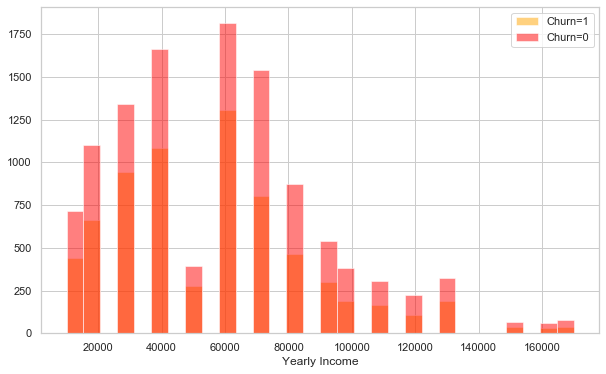

In [69]:
#differentiating  Yearly income of customers who have churned 
plt.figure(figsize=(10,6))
final_data[final_data['Churn']==1]['YearlyIncome'].hist(alpha=0.5,color='orange',
                                              bins=30,label='Churn=1')
final_data[final_data['Churn']==0]['YearlyIncome'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Yearly Income')

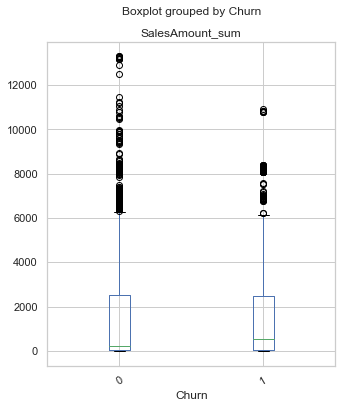

In [70]:
final_data.boxplot('SalesAmount_sum','Churn',rot = 30,figsize=(5,6))

In [69]:
#reviewing the no of records in the target field - Churn
final_data['Churn'].value_counts()

0    11437
1     7047
Name: Churn, dtype: int64

In [70]:
#Keep an hold out sample for scoring and deployment. 
#extract only churners
Churners = final_data.loc[final_data['Churn'] == 1] 
#Extract only first 6973 rows from Non churners
non_churners = final_data.loc[final_data['Churn'] == 0]
#Score_data = final_data.loc[final_data['Churn'] == 0].tail(6000)

In [71]:
#Counting Churners
Churners['Churn'].value_counts()

1    7047
Name: Churn, dtype: int64

In [72]:
#Counting non churners
non_churners['Churn'].value_counts()

0    11437
Name: Churn, dtype: int64

##### Splitting the Non churners data in to two groups 

In [73]:
# Randomly seperate the 11437 Non-Churners into 2 groups:
#   50% - Non_churners - for training, validating, and testing the model
#   50% - Score_data - for scoring the model
# Used the train_test_split functions to achieve random selection of the data
#This is not for model purposes or data partitioning, its only to split the data and select a hold out sample
Score_data,Non_churners = train_test_split(non_churners,test_size=0.5,random_state=42)

In [74]:
Non_churners['Churn'].value_counts()

0    5719
Name: Churn, dtype: int64

In [75]:
# This is the hold out sample for scoring/deployment
Score_data['Churn'].value_counts()


0    5718
Name: Churn, dtype: int64

In [76]:
Score_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median,BirthDate,YearlyIncome,TotalChildren,NumberChildrenAtHome,NumberCarsOwned,DateFirstPurchase,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date,K_Cluster,Churn,MaritalStatus_M,MaritalStatus_S,Gender_F,Gender_M,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School,EnglishOccupation_Clerical,EnglishOccupation_Management,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
13291,24291,539.99,539.99,539.99,539.99,539.99,1,1,1,1.0,1.0,2013-12-09,0,0,0,0.0,0.0,1979-09-08,50000.0,0,0,2,2013-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,34,2013-12-09,2013-06-28,3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0
12820,23820,37.27,37.27,37.27,37.27,37.27,3,3,3,3.0,3.0,2013-12-15,0,0,0,0.0,0.0,1979-01-31,40000.0,0,0,0,2013-12-15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,34,2013-12-15,2013-06-28,3,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
7630,18630,48.97,48.97,48.97,48.97,48.97,3,3,3,3.0,3.0,2013-12-16,0,0,0,0.0,0.0,1976-08-19,20000.0,0,0,2,2013-12-16,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,37,2013-12-16,2013-06-28,3,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
3172,14172,75.74,39.47,36.27,37.87,37.87,6,3,3,3.0,3.0,2013-09-18,162,162,0,81.0,81.0,1949-10-19,130000.0,3,4,4,2013-04-09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,63,2013-09-18,2013-06-28,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
5957,16957,39.98,39.98,39.98,39.98,39.98,2,2,2,2.0,2.0,2013-12-21,0,0,0,0.0,0.0,1975-05-20,60000.0,1,0,0,2013-12-21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,38,2013-12-21,2013-06-28,3,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0


In [77]:
#Append Churners and non churners excluding the hold out sample for scoring
model_data = pd.concat([Churners, Non_churners],ignore_index=True)

In [78]:
#
model_data['Churn'].value_counts()

1    7047
0    5719
Name: Churn, dtype: int64

#### Target variable -
#### Churner= 1 & Non Churner=0  
#### Churn is the rate at which customers stop doing business 

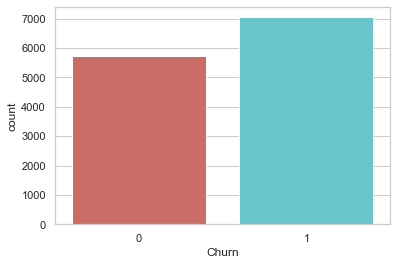

<Figure size 432x288 with 0 Axes>

In [77]:
#Display the distribution of the target variable - 0 = Non Churner - 1 = Churner
sns.countplot(x='Churn', data = model_data, palette = 'hls')
plt.show()
plt.savefig('count_plot')

In [79]:
#measures of central tendencies - investigating the difference between the averages of independent variables vs the target variables
model_data.groupby('Churn').mean()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,diff_sum,diff_max,diff_min,diff_mean,diff_median,YearlyIncome,TotalChildren,NumberChildrenAtHome,NumberCarsOwned,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,K_Cluster,MaritalStatus_M,MaritalStatus_S,Gender_F,Gender_M,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School,EnglishOccupation_Clerical,EnglishOccupation_Management,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
Churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,19679.078510,1576.247997,998.327363,687.837309,842.29389,841.39218,3.573877,2.649939,1.904878,2.273014,2.267354,185.082007,172.736667,0.0,83.097175,77.244536,58539.954538,1.867809,1.072565,1.540129,0.071617,0.181681,0.087637,0.882209,0.061628,0.072936,0.049378,5.870082,44.226613,1.196188,0.549921,0.450079,0.497115,0.502885,0.291659,0.170309,0.182375,0.273999,0.081658,0.155796,0.176779,0.125197,0.305998,0.236230,0.322609,0.677391,0.344466,0.165938,0.137262,0.166987,0.185347
1,20984.284802,1559.156009,1145.515796,868.235938,1006.12676,1004.95849,2.788988,2.424862,1.939691,2.181933,2.181354,107.566624,105.574287,0.0,51.721158,49.817369,55819.497659,1.812686,0.924081,1.454378,0.144529,0.178086,0.066490,0.811924,0.135945,0.062432,0.026065,3.399319,43.137505,0.858947,0.531006,0.468994,0.492550,0.507450,0.286789,0.178232,0.176245,0.269760,0.088974,0.157656,0.159217,0.130694,0.283667,0.268767,0.332482,0.667518,0.341564,0.186320,0.124450,0.185185,0.162480


Text(0, 0.5, 'Frequency')

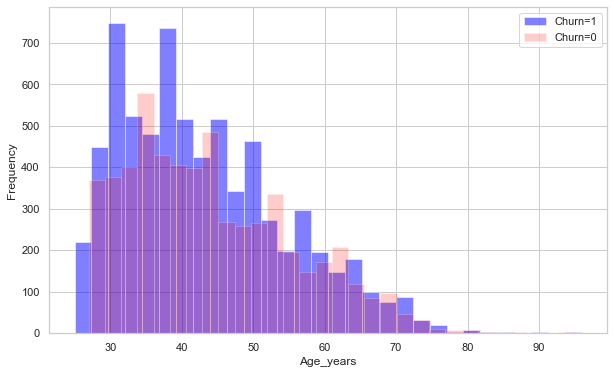

In [79]:
#Most of the customers in this dataset are in the age range of 30–40.
plt.figure(figsize=(10,6))
model_data[model_data['Churn']==1]['Age_years'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
model_data[model_data['Churn']==0]['Age_years'].hist(alpha=0.2,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Age_years')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

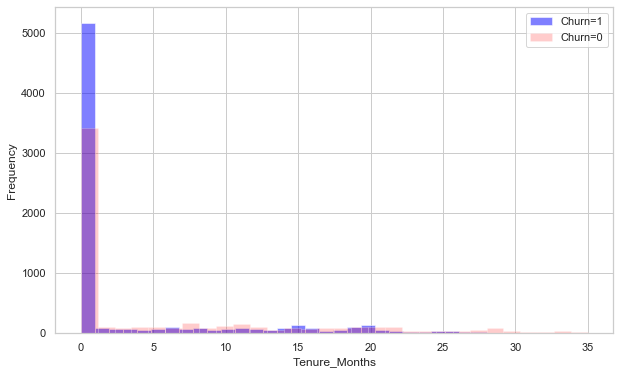

In [85]:
#Investigating Churn versus Tenure Months.
plt.figure(figsize=(10,6))
model_data[model_data['Churn']==1]['Tenure_Months'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
model_data[model_data['Churn']==0]['Tenure_Months'].hist(alpha=0.2,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Tenure_Months')
plt.ylabel('Frequency')

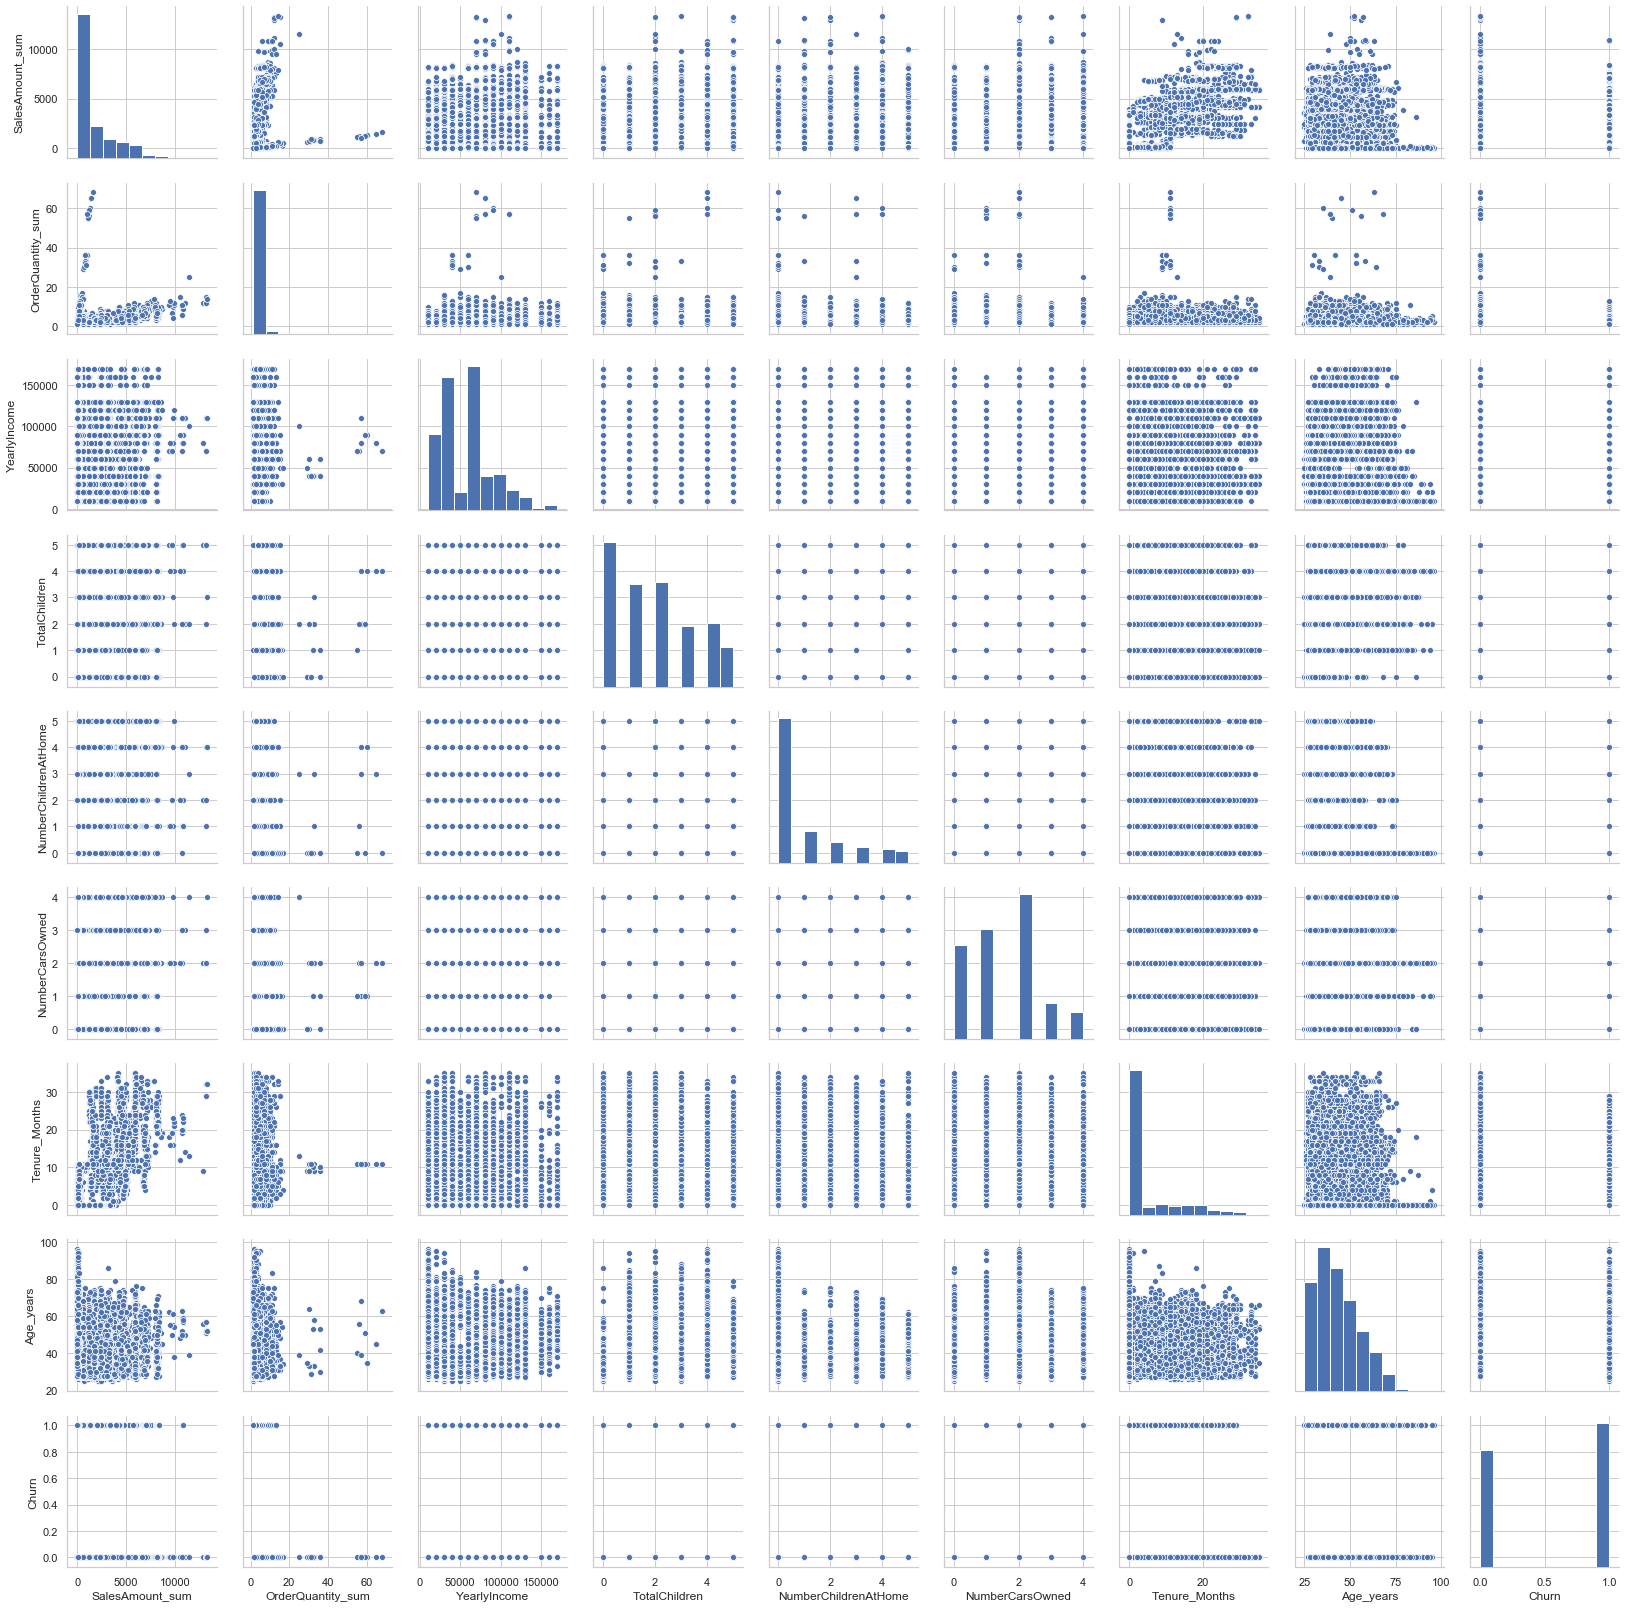

In [86]:
#plots
x = model_data[['SalesAmount_sum', 'OrderQuantity_sum', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'NumberCarsOwned', 'Tenure_Months', 'Age_years', 'Churn']]
sns.pairplot(x)

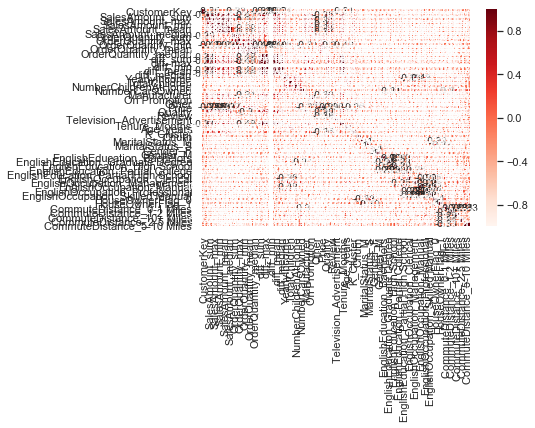

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
plt.figure(figsize=(12,10))
%matplotlib inline
corr = model_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True, cmap=plt.cm.Reds)

In [88]:
#check the correlation of the input features with one another.
#print(model_data.corr())

In [80]:
#replace missing values with most frequent values
model_data = model_data.fillna(model_data.mode().iloc[0])

In [81]:
#Carry out a statistical test to understand key statistical elements
model_data.describe()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,diff_sum,diff_max,diff_min,diff_mean,diff_median,YearlyIncome,TotalChildren,NumberChildrenAtHome,NumberCarsOwned,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,K_Cluster,Churn,MaritalStatus_M,MaritalStatus_S,Gender_F,Gender_M,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School,EnglishOccupation_Clerical,EnglishOccupation_Management,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
count,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.0,12766.00000,12766.000000,12766.000000,12766.000000,12766.00000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000
mean,20399.569560,1566.812995,1079.577315,787.419726,932.731790,931.682936,3.140608,2.525693,1.924095,2.222736,2.219881,142.292496,135.662149,0.0,65.77720,62.104379,57038.226539,1.837381,0.99060,1.492793,0.102303,0.164891,0.069795,0.856650,0.093843,0.061648,0.033605,4.506188,43.625411,1.010027,0.552013,0.539480,0.460520,0.494595,0.505405,0.288971,0.174683,0.178991,0.271659,0.085696,0.156823,0.167084,0.128231,0.293671,0.254191,0.328059,0.671941,0.342864,0.177189,0.130190,0.177033,0.172724
std,5368.165397,2077.263124,1253.598146,950.332704,1064.133549,1062.936184,2.412927,1.102753,1.051045,0.936168,0.947683,246.468238,237.044916,0.0,115.34301,112.671114,32126.263026,1.611757,1.51356,1.129140,0.303058,0.371097,0.254811,0.350443,0.291622,0.240525,0.180217,7.912125,11.573064,0.982762,0.497307,0.498458,0.498458,0.499990,0.499990,0.453302,0.379710,0.383360,0.444832,0.279926,0.363648,0.373066,0.334360,0.455461,0.435422,0.469525,0.469525,0.474685,0.381844,0.336525,0.381711,0.378024
min,11000.000000,2.290000,2.290000,2.290000,2.290000,2.290000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.00000,0.000000,10000.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15809.250000,49.480000,43.587500,38.880000,39.980000,39.980000,2.000000,2.000000,1.000000,1.500000,1.500000,0.000000,0.000000,0.0,0.00000,0.000000,30000.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20429.000000,384.465000,195.590000,191.270000,191.270000,191.270000,3.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.0,0.00000,0.000000,60000.000000,2.000000,0.00000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,41.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00

In [91]:
model_data.dtypes

CustomerKey                                      int64
SalesAmount_sum                                float64
SalesAmount_max                                float64
SalesAmount_min                                float64
SalesAmount_mean                               float64
SalesAmount_median                             float64
OrderQuantity_sum                                int64
OrderQuantity_max                                int64
OrderQuantity_min                                int64
OrderQuantity_mean                             float64
OrderQuantity_median                           float64
OrderDate_max                           datetime64[ns]
diff_sum                                         int32
diff_max                                         int32
diff_min                                         int32
diff_mean                                      float64
diff_median                                    float64
BirthDate                                       object
YearlyInco

<a id='pdfs'> </a>
## Preparing data for Feature Slection 

In [82]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
#http://localhost:8888/notebooks/Downloads/Churn%20Model%20From%20Scratch%20(1).ipynb
#4.-Variable-Selection-using-Python---Vote-based-approach
# Encoding the categorical variable
fit = model_data.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    model_data[i] = d[i].transform(model_data[i].fillna('NA'))

In [83]:
model_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median,BirthDate,YearlyIncome,TotalChildren,NumberChildrenAtHome,NumberCarsOwned,DateFirstPurchase,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date,K_Cluster,Churn,MaritalStatus_M,MaritalStatus_S,Gender_F,Gender_M,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School,EnglishOccupation_Clerical,EnglishOccupation_Management,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,2.0,2013-05-03,835,730,0,278.333333,105.0,3160,90000.0,2,0,0,21,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27,41,2013-05-03,2013-06-28,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
1,11002,8114.04,3399.99,2294.99,2704.680000,2419.06,4,2,1,1.333333,1.0,2013-02-23,778,724,0,259.333333,54.0,3059,60000.0,3,3,1,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25,42,2013-02-23,2013-06-28,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
2,11003,8139.29,3399.99,2318.96,2713.096667,2420.34,9,4,1,3.000000,4.0,2013-05-10,863,738,0,287.666667,125.0,3439,70000.0,0,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28,39,2013-05-10,2013-06-28,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,11004,8196.01,3399.99,2376.96,2732.003333,2419.06,6,3,1,2.000000,2.0,2013-05-01,829,730,0,276.333333,99.0,4357,80000.0,5,5,4,25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27,33,2013-05-01,2013-06-28,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
4,11005,8121.33,3374.99,2362.27,2707.110000,2384.07,6,4,1,2.000000,1.0,2013-05-02,854,755,0,284.666667,99.0,3901,70000.0,0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,28,36,2013-05-02,2013-06-28,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


In [83]:
#Select features and target
features = model_data[model_data.columns.difference(['Churn','CustomerKey','K_Custer','OrderDate_max','SalesAmount_max', 'SalesAmount_min','SalesAmount_mean', 'SalesAmount_median','OrderQuantity_min','OrderQuantity_max', 'OrderQuantity_mean', 'OrderQuantity_median','Cuttoff_date','Last_purchase_date','DateFirstPurchase','BirthDate'])]
labels = model_data['Churn']

<a id='rf'> </a>
##  1)Feature Importance using Random forest 

In [84]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print (accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9878583738054206


In [85]:
#important random forest features
from pandas import DataFrame
ranFeat = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [86]:
ranFeat = ranFeat.reset_index()
ranFeat.sort_values(['RF'],ascending=0)

,index,RF
32,SalesAmount_sum,0.160291
20,K_Cluster,0.139826
0,Age_years,0.102979
27,OrderQuantity_sum,0.058042
36,YearlyIncome,0.051946
41,diff_sum,0.039252
37,diff_max,0.034342
35,TotalChildren,0.033229
39,diff_median,0.031810
24,NumberCarsOwned,0.029615


<a id='rfe'> </a>
## 2) Recursive Feature Elimination

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [88]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

In [89]:
Selected[Selected['RFE'] == True]

,index,RFE
1,CommuteDistance_0-1 Miles,True
2,CommuteDistance_1-2 Miles,True
4,CommuteDistance_2-5 Miles,True
6,EnglishEducation_Bachelors,True
7,EnglishEducation_Graduate Degree,True
9,EnglishEducation_Partial College,True
10,EnglishEducation_Partial High School,True
15,EnglishOccupation_Skilled Manual,True
16,Gender_F,True
17,Gender_M,True


<a id='etc'> </a>
##  3) Feature Importance using Extra tree Classifier 

In [90]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09630694 0.01176276 0.00945991 0.00837704 0.01172045 0.00852714
 0.0101406  0.0082394  0.00878491 0.00988591 0.00390467 0.00849538
 0.00601896 0.00567015 0.01002115 0.01009401 0.01861641 0.0164369
 0.01235023 0.01125929 0.13069872 0.01299287 0.01471964 0.01501189
 0.03214316 0.02568341 0.01261083 0.07064161 0.00966788 0.01005852
 0.01581875 0.00539786 0.13336066 0.00562384 0.02207403 0.03767341
 0.04969228 0.02311038 0.03133833 0.02897893 0.         0.02663079]


In [91]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [92]:
FI = FI.reset_index()

In [93]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
32,SalesAmount_sum,0.133361
20,K_Cluster,0.130699
0,Age_years,0.096307
27,OrderQuantity_sum,0.070642
36,YearlyIncome,0.049692
35,TotalChildren,0.037673
24,NumberCarsOwned,0.032143
38,diff_mean,0.031338
39,diff_median,0.028979
41,diff_sum,0.026631


<a id='chi'> </a>
## 4) Chi Square

In [94]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=10)
fit = model.fit(features.abs(), labels)

In [95]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features.columns)

In [96]:
chi_sq = chi_sq.reset_index()

In [97]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
36,YearlyIncome,409625.71
41,diff_sum,133310.18
37,diff_max,104969.47
38,diff_mean,47248.69
39,diff_median,38239.24
34,Tenure_Months,4276.83
27,OrderQuantity_sum,619.26
32,SalesAmount_sum,588.62
20,K_Cluster,355.48
30,Quality,148.41


#### Combine all 

In [98]:
from functools import reduce
dfs = [ranFeat, Selected, FI, chi_sq]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

<a id='vfs'> </a>
## Vote base FS

In [99]:
columns = ['RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)

In [100]:
score_table['final_score'] = score_table.sum(axis=1)

In [101]:
score_table.sort_values('final_score',ascending=0)

,index,RF,Extratrees,Chi_Square,RFE,final_score
20,K_Cluster,1,1,0,1,3
36,YearlyIncome,1,1,1,0,3
0,Age_years,1,1,0,0,2
32,SalesAmount_sum,1,1,0,0,2
27,OrderQuantity_sum,1,1,0,0,2
28,Other,0,0,0,1,1
1,CommuteDistance_0-1 Miles,0,0,0,1,1
22,MaritalStatus_M,0,0,0,1,1
23,MaritalStatus_S,0,0,0,1,1
30,Quality,0,0,0,1,1


<a id='mc'> </a>
## Multicollinearity

In [102]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [103]:
features = features[list(score_table[score_table['final_score'] >= 2]['index'])]

In [104]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

In [105]:
list(vif['Features'])

['Age_years',
 'K_Cluster',
 'OrderQuantity_sum',
 'SalesAmount_sum',
 'YearlyIncome']

In [106]:
features.describe()

,Age_years,K_Cluster,OrderQuantity_sum,SalesAmount_sum,YearlyIncome
count,12766.00,12766.00,12766.00,12766.00,12766.00
mean,43.63,1.01,3.14,1566.81,57038.23
std,11.57,0.98,2.41,2077.26,32126.26
min,25.00,0.00,1.00,2.29,10000.00
25%,34.00,0.00,2.00,49.48,30000.00
50%,41.00,1.00,3.00,384.47,60000.00
75%,51.00,2.00,4.00,2482.23,70000.00
max,96.00,3.00,68.00,13294.27,170000.00


In [107]:
#Merge the best list to churn variable
final_vars = list(vif['Features']) + ['Churn']

In [108]:
df1 = model_data[final_vars].fillna(0)

In [109]:
df1.head()

,Age_years,K_Cluster,OrderQuantity_sum,SalesAmount_sum,YearlyIncome,Churn
0,41,1,8,8248.99,90000.00,1
1,42,1,4,8114.04,60000.00,1
2,39,1,9,8139.29,70000.00,1
3,33,1,6,8196.01,80000.00,1
4,36,1,6,8121.33,70000.00,1


<a id='tt'> </a>
### Training & Testing Different Models

<a id='rf1'> </a>
### Random Forest

In [110]:
# splitting the data in to traing and testing set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size = 0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']

In [111]:
all_features = pd.concat([features_train, features_test])
all_labels = pd.concat([label_train, label_test])

In [112]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9712756234495364 0.6912081456823967 0.9963092485827707 0.7687140568428563


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [113]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,3374,81
1,139,4065


In [114]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1479,785
1,792,2051


<a id='lr'> </a>
### Logistic Regression

In [116]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)


0.6109152630891761 0.6150381828862346 0.6201178052464678 0.627302474989715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [117]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1460,1995
1,985,3219


In [118]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,973,1291
1,675,2168


<a id='nb'> </a>
### Naive Bayes

In [119]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.5891108499804152 0.5901703544155081 0.6026822019136898 0.6051159067774174


In [120]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,575,2882
1,268,3934


In [121]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,366,1896
1,169,2676


<a id='gb'> </a>
## Gradient Boosting

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.7443530487008748 0.7280203642059918 0.811173873411168 0.7840332059773618


In [121]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1813,1642
1,316,3888


In [122]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1120,1144
1,245,2598


<a id='fm'> </a>
## Final Model 

In [123]:
#Train the final model on all the dataset
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(all_features,all_labels)

pred_train = clf.predict(all_features)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,all_labels)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(all_labels), clf.predict_proba(all_features)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train, accuracy_test,auc_train,auc_test)

0.7411875293749021 0.7399647542588604 0.8019457843972351 0.7995822142041266


In [124]:
pd.crosstab(all_labels,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2420,3299
1,1059,5988


<a id='sfm'> </a>
## Saving the model for future use

In [125]:
import pandas
from sklearn.externals import joblib

filename = 'final_model.model'
i = [d,clf]
joblib.dump(i,filename)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['final_model.model']

<a id='sd'> </a>
## Score data

In [126]:
all_features.dtypes

Age_years              int32
K_Cluster              int64
OrderQuantity_sum      int64
SalesAmount_sum      float64
YearlyIncome         float64
dtype: object

In [127]:
#Prepare score data to ensure the attributes of the modelling data matches that of the scoring data
#Score_data

#replace missing values with most frequent values
Score_data_sel = Score_data.fillna(Score_data.mode().iloc[0])

#Select features and target
Score_data_sel = Score_data_sel[['Age_years',
                                 'K_Cluster',
                                 'OrderQuantity_sum',
                                 'SalesAmount_sum',
                                 'YearlyIncome',]]

In [128]:
#Select features and target
Score_data_sel.head(5)

,Age_years,K_Cluster,OrderQuantity_sum,SalesAmount_sum,YearlyIncome
13291,34,3,1,539.99,50000.00
12820,34,3,3,37.27,40000.00
7630,37,3,3,48.97,20000.00
3172,63,1,6,75.74,130000.00
5957,38,3,2,39.98,60000.00


In [129]:
# Use the code to load the model
filename = 'final_model.model'
from sklearn.externals import joblib
d,clf=joblib.load(filename)

In [130]:
#Score the final model (gradient boosting) 
pred_train = clf.predict(Score_data_sel)

In [131]:
def score_new(features,clf):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    return(score)

In [132]:
scores = score_new(Score_data_sel,clf)

In [133]:
# How many 0s and 1s are there
# Churner= 1 & Non Churner=0
print('There are', np.count_nonzero(pred_train == 0), '0s')

print('There are', np.count_nonzero(pred_train == 1), '1s')

There are 2967 0s
There are 2751 1s


In [134]:
Score_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,diff_sum,diff_max,diff_min,diff_mean,diff_median,BirthDate,YearlyIncome,TotalChildren,NumberChildrenAtHome,NumberCarsOwned,DateFirstPurchase,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Tenure_Months,Age_years,Last_purchase_date,Cuttoff_date,K_Cluster,Churn,MaritalStatus_M,MaritalStatus_S,Gender_F,Gender_M,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School,EnglishOccupation_Clerical,EnglishOccupation_Management,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
13291,24291,539.99,539.99,539.99,539.99,539.99,1,1,1,1.00,1.00,2013-12-09,0,0,0,0.00,0.00,1979-09-08,50000.00,0,0,2,2013-12-09,nan,nan,nan,nan,nan,nan,nan,0,34,2013-12-09,2013-06-28,3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0
12820,23820,37.27,37.27,37.27,37.27,37.27,3,3,3,3.00,3.00,2013-12-15,0,0,0,0.00,0.00,1979-01-31,40000.00,0,0,0,2013-12-15,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0,34,2013-12-15,2013-06-28,3,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
7630,18630,48.97,48.97,48.97,48.97,48.97,3,3,3,3.00,3.00,2013-12-16,0,0,0,0.00,0.00,1976-08-19,20000.00,0,0,2,2013-12-16,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0,37,2013-12-16,2013-06-28,3,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
3172,14172,75.74,39.47,36.27,37.87,37.87,6,3,3,3.00,3.00,2013-09-18,162,162,0,81.00,81.00,1949-10-19,130000.00,3,4,4,2013-04-09,0.00,0.00,0.00,1.00,0.00,0.00,0.00,5,63,2013-09-18,2013-06-28,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
5957,16957,39.98,39.98,39.98,39.98,39.98,2,2,2,2.00,2.00,2013-12-21,0,0,0,0.00,0.00,1975-05-20,60000.00,1,0,0,2013-12-21,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0,38,2013-12-21,2013-06-28,3,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0


In [135]:
# Put the result in a dataframe
Final = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'Churn_Flag':pred_train})

In [136]:
# Merge the Final data to the custtbl to do some demographics profiling
Final_ouput = pd.merge(ct,
                 Final,
                 on='CustomerKey',how = 'inner')
Final_ouput.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Churn_Flag
0,11012,1979-01-14,M,F,100000.00,2,0,Bachelors,Management,1,2,2013-03-16,1-2 Miles,0
1,11013,1979-08-03,M,M,100000.00,2,0,Bachelors,Management,1,3,2013-04-13,0-1 Miles,0
2,11018,1955-10-06,S,M,30000.00,2,0,Partial College,Clerical,1,2,2011-01-17,5-10 Miles,0
3,11019,1983-09-04,S,M,40000.00,0,0,High School,Skilled Manual,0,2,2013-02-12,5-10 Miles,0
4,11023,1984-04-09,M,M,40000.00,0,0,Partial College,Skilled Manual,1,1,2013-02-17,1-2 Miles,0


In [138]:
Final_ouput.count()

CustomerKey             5718
BirthDate               5718
MaritalStatus           5718
Gender                  5718
YearlyIncome            5718
TotalChildren           5718
NumberChildrenAtHome    5718
EnglishEducation        5718
EnglishOccupation       5718
HouseOwnerFlag          5718
NumberCarsOwned         5718
DateFirstPurchase       5718
CommuteDistance         5718
Churn_Flag              5718
dtype: int64

In [139]:
#scores.count()
#pred_train.count()
#Score_data.CustomerKey.count()
#Final.head(5)
#clf.predict_proba(features)
#clf.predict_proba(features)[:,1]
prob = scores[['SCORE']].values.squeeze()

In [140]:
prob

array([0.01687549, 0.01524537, 0.01503754, ..., 0.45959792, 0.21091324,
       0.64846824])

In [141]:
#, 'Score':scores.SCORE, 'Decile':scores.DECILE
#Final_ = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'Score':clf.predict_proba(features)[:,1]})
#Final_ = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'SCORE':clf.predict_proba(features)[:,1]})
Final_ = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'Churn_Probability':prob})


In [142]:
Final_.head(5)

,CustomerKey,Churn_Probability
13291,24291,0.02
12820,23820,0.02
7630,18630,0.02
3172,14172,0.33
5957,16957,0.02


In [143]:
# Merge the probabilities to the
Final = pd.merge(Final_ouput,
                 Final_,
                 on='CustomerKey',how = 'inner')
Final.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Churn_Flag,Churn_Probability
0,11012,1979-01-14,M,F,100000.00,2,0,Bachelors,Management,1,2,2013-03-16,1-2 Miles,0,0.37
1,11013,1979-08-03,M,M,100000.00,2,0,Bachelors,Management,1,3,2013-04-13,0-1 Miles,0,0.01
2,11018,1955-10-06,S,M,30000.00,2,0,Partial College,Clerical,1,2,2011-01-17,5-10 Miles,0,0.08
3,11019,1983-09-04,S,M,40000.00,0,0,High School,Skilled Manual,0,2,2013-02-12,5-10 Miles,0,0.12
4,11023,1984-04-09,M,M,40000.00,0,0,Partial College,Skilled Manual,1,1,2013-02-17,1-2 Miles,0,0.02
